# Pre Test set

x is 224 and y is 224 and z is 11
(50176, 11)


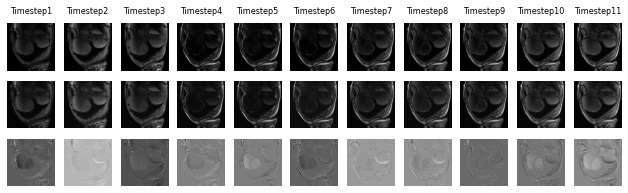

In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_pre_dataset/test/0387056_20140423_MOLLI_3.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
low, sparse, U, S, V = rpca_godec(M, rank=5)
low_matrix = low.reshape((x, y, z))
sparse_matrix = sparse.reshape((x, y, z))

fig = plt.figure(figsize=(11, 3))
title_font_size=8
title_pad = 10
for i in range(z):
    ax1 = fig.add_subplot(3, 11, 1+i)
    plt.imshow(vols[..., i], cmap='gray')
    plt.axis('off')
    ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

    ax2 = fig.add_subplot(3, 11, 12+i)
    plt.imshow(low_matrix[..., i], cmap='gray')
    plt.axis('off')

    ax3 = fig.add_subplot(3, 11, 23+i)
    plt.imshow(sparse_matrix[..., i], cmap='gray')
    plt.axis('off')

## Test Metrics

### Original volume

#### First Eigen Component percentage

In [2]:
from scripts.utils import *
orig_path = 'data/MOLLI_pre_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.7867720274668718


#### T1 fitting

Mean of t1err is 11.072921129848977 and std is 4.963850319538608
Mean of t1err is 14.217012343355398 and std is 7.345939012337131


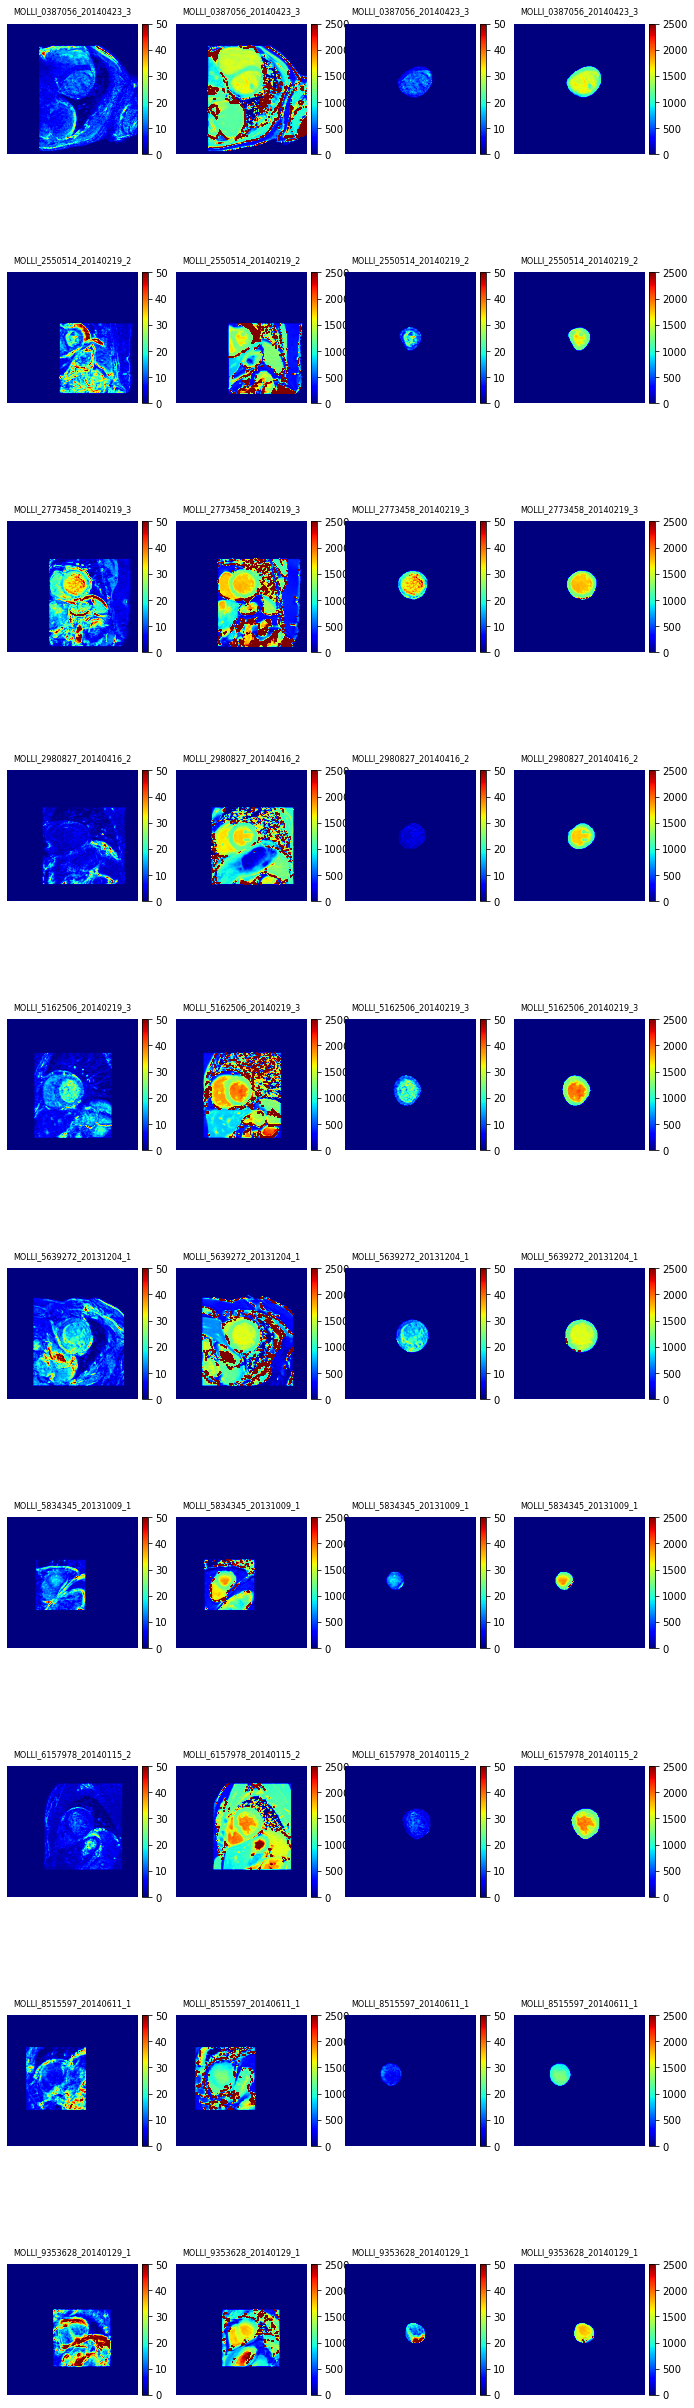

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = "data/MOLLI_pre_dataset/T1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
orig_t1err_square_list = []
orig_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    orig_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    orig_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_square_list))} and std is {np.std(np.array(orig_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_heart_list))} and std is {np.std(np.array(orig_t1err_heart_list))}")
plt.savefig(f"data/MOLLI_pre_dataset/T1_SDerr/orig_t1err.png", dpi=300)

### Round 1

In [4]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

In [5]:
r = 1
root = f"results/MOLLI_pre/group/rank_5_5_3/tc/smooth/image_loss_weight1/cycle_loss_weight0.01/weight0.001/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre"
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [6]:
path = f"{base_path}/moved"
r1_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r1_pca_changes.append(org_dis)
print(f"Mean of Round 1 PCA is {np.mean(np.array(r1_pca_changes))} and std is {np.std(np.array(r1_pca_changes))}")

Mean of Round 1 PCA is 0.7922568851562277 and std is 0.024616261537271946


#### Jacobian Determination

In [7]:
r1_folding_ratio_list = []
r1_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r1_folding_ratio_list.append(folding_ratio)
    r1_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r1_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r1_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0015497092390432954


#### T1 fitting

Mean of t1err is 10.362594929345288 and std is 4.602952798681194
Mean of t1err is 13.88067253106119 and std is 7.079775650791522


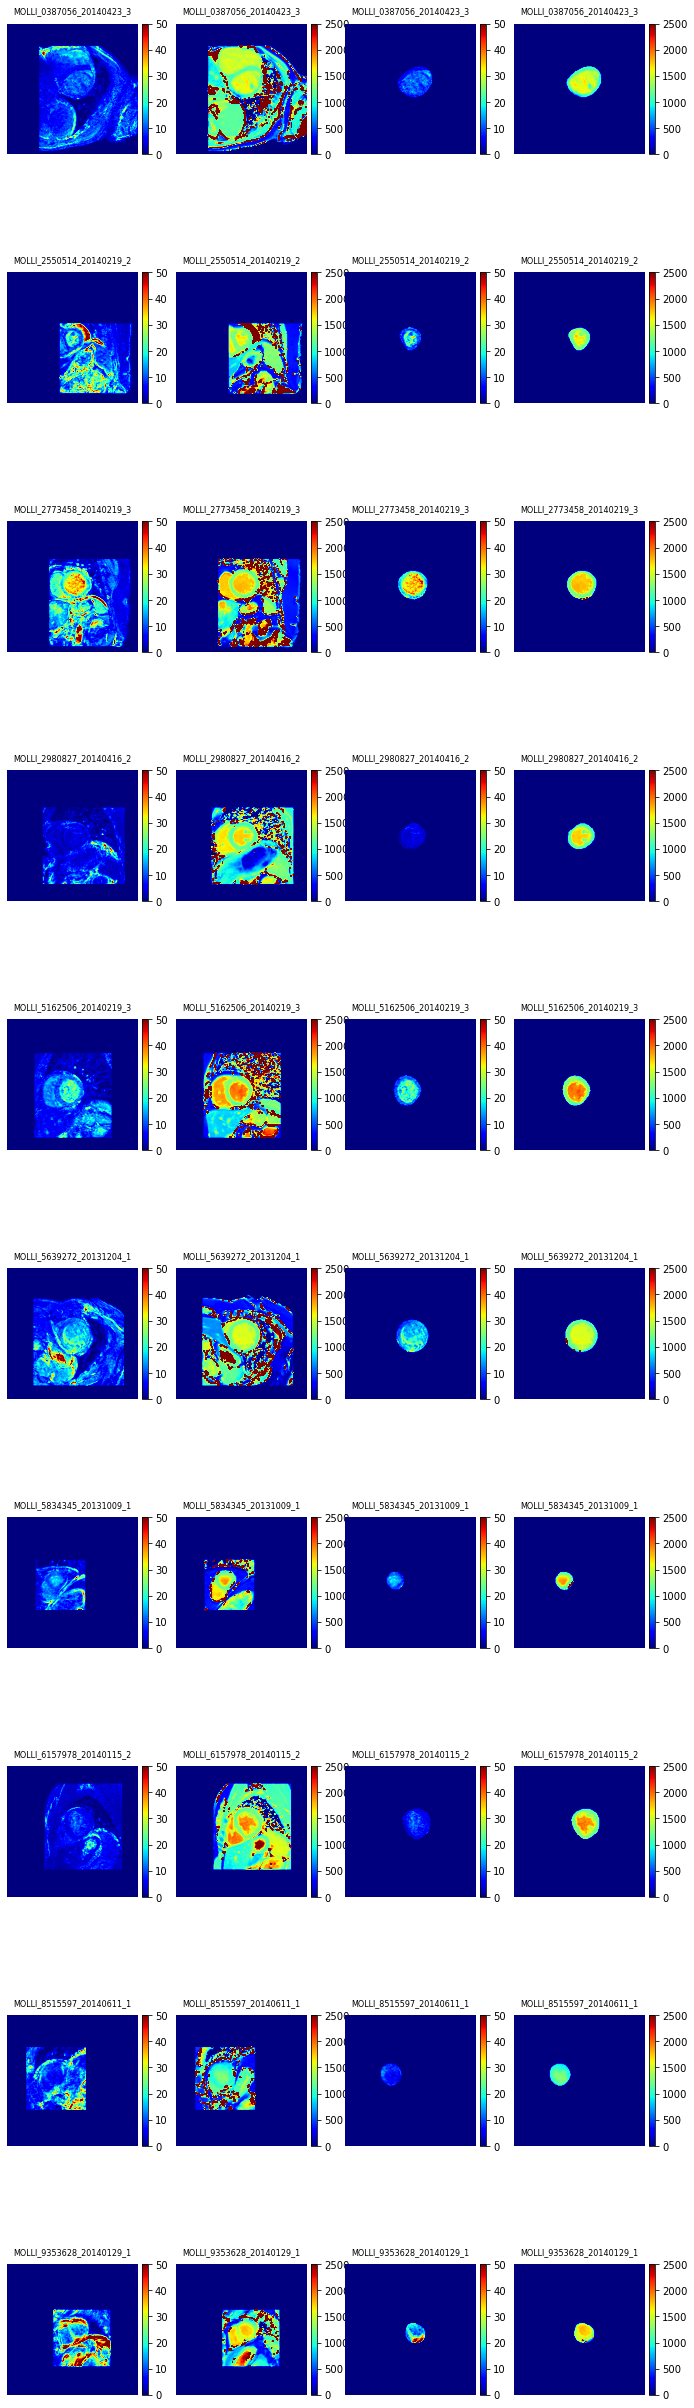

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r1_t1err_square_list = []
r1_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r1_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r1_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_square_list))} and std is {np.std(np.array(r1_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_heart_list))} and std is {np.std(np.array(r1_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Round 2

In [9]:
r = 2
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [10]:
path = f"{base_path}/moved"
r2_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r2_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r2_pca_changes))} and std is {np.std(np.array(r2_pca_changes))}")

Mean of Round 2 PCA is 0.7954244944713186 and std is 0.024125578583159894


#### Jacobian Determination

In [11]:
r2_folding_ratio_list = []
r2_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r2_folding_ratio_list.append(folding_ratio)
    r2_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r2_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r2_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0010619161184877157


#### T1 fitting

Mean of t1err is 10.088868557356111 and std is 4.403241804764384
Mean of t1err is 13.70231725114149 and std is 6.970833567993005


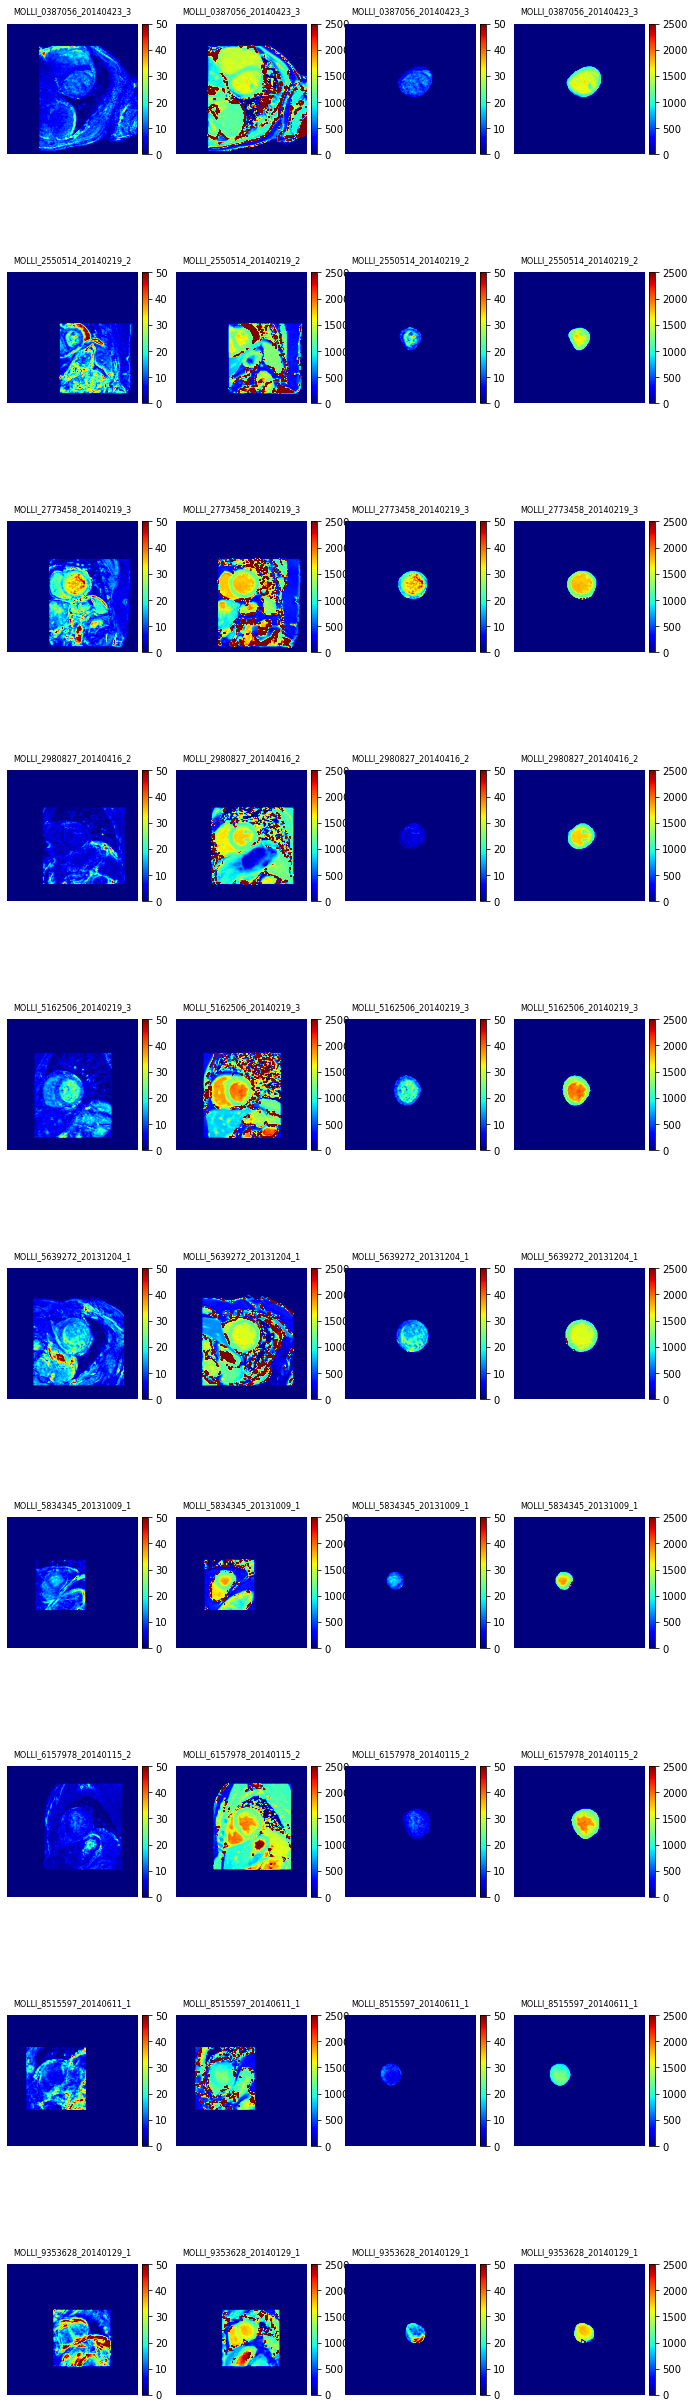

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r2_t1err_square_list = []
r2_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r2_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r2_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_square_list))} and std is {np.std(np.array(r2_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_heart_list))} and std is {np.std(np.array(r2_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Round 3

In [13]:
r = 3
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [14]:
path = f"{base_path}/moved"
r3_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r3_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r3_pca_changes))} and std is {np.std(np.array(r3_pca_changes))}")

Mean of Round 2 PCA is 0.7993446881332036 and std is 0.02471090454775323


#### Jacobian Determination

In [15]:
r3_folding_ratio_list = []
r3_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r3_folding_ratio_list.append(folding_ratio)
    r3_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r3_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r3_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0015785926952958107


#### T1 fitting

Mean of t1err is 10.003936117375238 and std is 4.338206832263817
Mean of t1err is 13.60725748972231 and std is 6.922860576502926


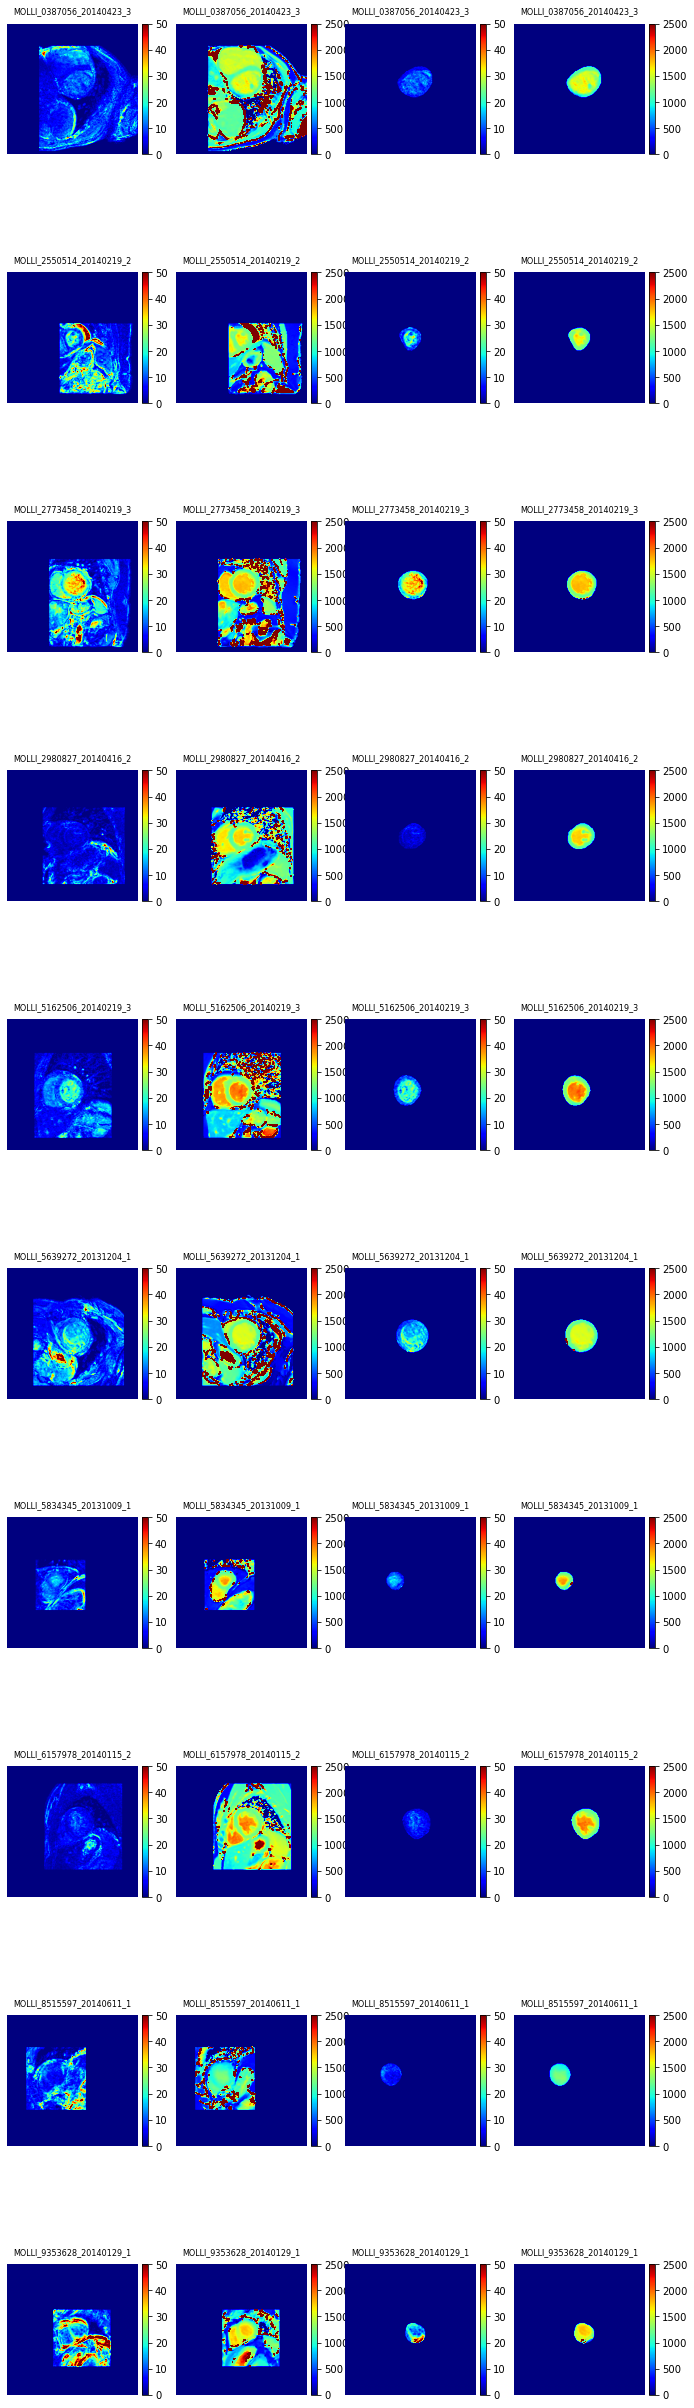

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget

path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r3_t1err_square_list = []
r3_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r3_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r3_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_square_list))} and std is {np.std(np.array(r3_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_heart_list))} and std is {np.std(np.array(r3_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Summary

In [17]:
import pandas as pd
df = pd.DataFrame()
df['Cases'] = subject_list
df['Raw Square T1err'] = orig_t1err_square_list
df['R1 Square T1err'] = r1_t1err_square_list
df['R2 Square T1err'] = r2_t1err_square_list
df['R3 Square T1err'] = r3_t1err_square_list
df['Square T1err diff'] = (df['Raw Square T1err'] - df['R3 Square T1err']) / df['Raw Square T1err']
df['Raw Heart T1err'] = orig_t1err_heart_list
df['R1 Heart T1err'] = r1_t1err_heart_list
df['R2 Heart T1err'] = r2_t1err_heart_list
df['R3 Heart T1err'] = r3_t1err_heart_list
df['Heart T1err diff'] = (df['Raw Heart T1err'] - df['R3 Heart T1err']) / df['Raw Heart T1err']
df

,Cases,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
0,MOLLI_0387056_20140423_3,7.539072,7.214912,7.183770,7.177077,0.048016,9.731935,9.708124,9.606970,9.557363,0.017938
1,MOLLI_2550514_20140219_2,12.360840,11.849658,11.760176,11.641299,0.058211,14.576425,14.363266,14.355903,14.179561,0.027226
2,MOLLI_2773458_20140219_3,13.635501,12.667150,12.281733,12.287174,0.098884,28.671655,28.377986,28.202838,28.150853,0.018164
3,MOLLI_2980827_20140416_2,5.785524,5.448293,5.294112,5.222888,0.097249,3.958349,4.073631,4.039001,4.068600,-0.027853
4,MOLLI_5162506_20140219_3,8.644283,8.003422,7.864789,7.768209,0.101347,17.141349,16.725776,16.486433,16.264226,0.051170
5,MOLLI_5639272_20131204_1,11.297461,10.636595,10.491754,10.469414,0.073295,17.010539,16.521426,16.378506,16.325767,0.040256
6,MOLLI_5834345_20131009_1,10.555566,9.346994,9.039178,8.986758,0.148624,12.637421,12.207785,11.986817,11.869594,0.060758
7,MOLLI_6157978_20140115_2,5.011841,4.864515,4.676523,4.657788,0.070643,6.933013,6.915901,6.853256,6.836762,0.013883
8,MOLLI_8515597_20140611_1,12.463286,11.768207,11.356877,11.183682,0.102670,7.736930,7.589265,7.526238,7.502275,0.030329
9,MOLLI_9353628_20140129_1,23.435838,21.826202,20.939774,20.645073,0.119081,23.772507,22.323565,21.587212,21.317574,0.103268


In [18]:
df.describe()

,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,11.072921,10.362595,10.088869,10.003936,0.091802,14.217012,13.880673,13.702317,13.607257,0.033514
std,5.232358,4.851938,4.641424,4.572872,0.029996,7.743300,7.462739,7.347904,7.297336,0.034390
min,5.011841,4.864515,4.676523,4.657788,0.048016,3.958349,4.073631,4.039001,4.068600,-0.027853
25%,7.815375,7.412039,7.354025,7.324860,0.071306,8.235682,8.118980,8.046421,8.016047,0.017995
50%,10.926513,9.991795,9.765466,9.728086,0.098066,13.606923,13.285526,13.171360,13.024578,0.028778
75%,12.437674,11.829296,11.659351,11.526895,0.102339,17.108646,16.674688,16.459451,16.310381,0.048441
max,23.435838,21.826202,20.939774,20.645073,0.148624,28.671655,28.377986,28.202838,28.150853,0.103268


In [19]:
df_2 = pd.DataFrame()
df_2['Cases'] = subject_list
df_2['Raw PCA'] = orig_pca_changes
df_2['R1 PCA'] = r1_pca_changes
df_2['R2 PCA'] = r2_pca_changes
df_2['R3 PCA'] = r3_pca_changes
df_2['R1 Det'] = r1_mag_det_jac_det_list
df_2['R2 Det'] = r2_mag_det_jac_det_list
df_2['R3 Det'] = r3_mag_det_jac_det_list
df_2['R1 Fold ratio'] = r1_folding_ratio_list
df_2['R2 Fold ratio'] = r2_folding_ratio_list
df_2['R3 Fold ratio'] = r3_folding_ratio_list
df_2

,Cases,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
0,MOLLI_0387056_20140423_3,0.806249,0.811007,0.812571,0.812738,0.001246,0.000840,0.000688,0.0,0.0,0.0
1,MOLLI_2550514_20140219_2,0.792254,0.798696,0.802485,0.806321,0.001504,0.001047,0.001559,0.0,0.0,0.0
2,MOLLI_2773458_20140219_3,0.773361,0.778581,0.782289,0.785843,0.001497,0.001036,0.001651,0.0,0.0,0.0
3,MOLLI_2980827_20140416_2,0.813012,0.817056,0.820268,0.825508,0.001510,0.001115,0.001544,0.0,0.0,0.0
4,MOLLI_5162506_20140219_3,0.787799,0.791953,0.794393,0.797584,0.001686,0.001177,0.001668,0.0,0.0,0.0
5,MOLLI_5639272_20131204_1,0.773060,0.777512,0.780030,0.783636,0.001456,0.001160,0.001749,0.0,0.0,0.0
6,MOLLI_5834345_20131009_1,0.757565,0.763965,0.768305,0.773104,0.001750,0.001115,0.001858,0.0,0.0,0.0
7,MOLLI_6157978_20140115_2,0.839774,0.844431,0.846864,0.853977,0.001402,0.000959,0.001446,0.0,0.0,0.0
8,MOLLI_8515597_20140611_1,0.770515,0.776945,0.780857,0.785191,0.001732,0.001156,0.001741,0.0,0.0,0.0
9,MOLLI_9353628_20140129_1,0.754133,0.762423,0.766183,0.769546,0.001715,0.001014,0.001882,0.0,0.0,0.0


In [20]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
mean,0.786772,0.792257,0.795424,0.799345,0.001550,0.001062,0.001579,0.0,0.0,0.0
std,0.026789,0.025948,0.025431,0.026048,0.000166,0.000106,0.000342,0.0,0.0,0.0
min,0.754133,0.762423,0.766183,0.769546,0.001246,0.000840,0.000688,0.0,0.0,0.0
25%,0.771151,0.777087,0.780237,0.784025,0.001466,0.001019,0.001548,0.0,0.0,0.0
50%,0.780580,0.785267,0.788341,0.791713,0.001507,0.001081,0.001659,0.0,0.0,0.0
75%,0.802750,0.807929,0.810050,0.811133,0.001708,0.001146,0.001747,0.0,0.0,0.0
max,0.839774,0.844431,0.846864,0.853977,0.001750,0.001177,0.001882,0.0,0.0,0.0


In [21]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
mean,0.786772,0.792257,0.795424,0.799345,0.001550,0.001062,0.001579,0.0,0.0,0.0
std,0.026789,0.025948,0.025431,0.026048,0.000166,0.000106,0.000342,0.0,0.0,0.0
min,0.754133,0.762423,0.766183,0.769546,0.001246,0.000840,0.000688,0.0,0.0,0.0
25%,0.771151,0.777087,0.780237,0.784025,0.001466,0.001019,0.001548,0.0,0.0,0.0
50%,0.780580,0.785267,0.788341,0.791713,0.001507,0.001081,0.001659,0.0,0.0,0.0
75%,0.802750,0.807929,0.810050,0.811133,0.001708,0.001146,0.001747,0.0,0.0,0.0
max,0.839774,0.844431,0.846864,0.853977,0.001750,0.001177,0.001882,0.0,0.0,0.0
